# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import Transfer


# Loading datasets

In [2]:
# French data
train = pd.read_csv('data/train.csv')
test1 = pd.read_csv('data/test1.csv')
test2 = pd.read_csv('data/test2.csv')
test3 = pd.read_csv('data/test3.csv')

# Italian data
train_it = pd.read_csv('data/train_it.csv')
test1_it = pd.read_csv('data/test1_it.csv')
test2_it = pd.read_csv('data/test2_it.csv')


# Loading experts

### Forecasts

In [3]:
# French data
gamtrain = pd.read_csv('data/experts/gamtrain_forecast.csv')['x']
gam1 = pd.read_csv('data/experts/gam1_forecast.csv')['x']
gam2 = pd.read_csv('data/experts/gam2_forecast.csv')['x']
gbm1 = pd.read_csv('data/experts/gbm1_forecast.csv')['x']
gbm2 = pd.read_csv('data/experts/gbm2_forecast.csv')['x']

# Italian data
gamittrain = pd.read_csv('data/experts/gamit_forecast.csv')['x']
gam1_it = pd.read_csv('data/experts/gam1it_forecast.csv')['x']
gam2_it = pd.read_csv('data/experts/gam2it_forecast.csv')['x']
gbm1_it = pd.read_csv('data/experts/gbm1it_forecast.csv')['x']
gbm2_it = pd.read_csv('data/experts/gbm2it_forecast.csv')['x']


### Spline

In [4]:
# French data
basis = pd.read_csv('data/experts/basis_france.csv')
basis1 = pd.read_csv('data/experts/basis1_france.csv')
basis2 = pd.read_csv('data/experts/basis2_france.csv')
betas = pd.read_csv('data/experts/betas_france.csv')

# Italian data
basis_it = pd.read_csv('data/experts/basis_it.csv')
basis1_it = pd.read_csv('data/experts/basis1_it.csv')
basis2_it = pd.read_csv('data/experts/basis2_it.csv')
betas_it = pd.read_csv('data/experts/betas_it.csv')


# Transfer learning

### Test 1

In [5]:
tr_te1 = Transfer(betas, betas_it, basis1, basis1_it, gam1, gam1_it, K=75)
ft_te1 = tr_te1.gam_ft()

100%|██████████| 1488/1488 [00:39<00:00, 37.83it/s]


### Test 2

In [6]:
tr_te2 = Transfer(betas, betas_it, basis2, basis2_it, gam2, gam2_it, K=75)
ft_te2 = tr_te2.gam_ft()

100%|██████████| 2544/2544 [01:19<00:00, 31.86it/s]


# Plotting the results

In [7]:
def display_plots(type='test1', method='ft'):
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    plt.figure(figsize=(16, 8))
    plt.xlabel = 'Time'
    if type == 'test1':
        if method == 'ft':
            plt.title = 'FineTuning on Test1 data'
            plt.plot(gam1, '--', label='GAM' + ', MAPE: ' + str(round(mape(test1['Consommation'], gam1), 2)), alpha=.7)
            plt.plot(ft_te1, '--', label='GAM FT' + ', MAPE: ' + str(round(mape(test1['Consommation'], ft_te1), 2)), alpha=.7)
            plt.plot(test1['Consommation'], label='Observed', color='black', alpha=.3)
        elif method == 'delta':
            plt.plot(gam1, '--', label='GAM' + ', MAPE: ' + str(round(mape(test1['Consommation'], gam1), 2)), alpha=.7)
            plt.plot(ft_delta1, '--', label='GAM Delta' + ', MAPE: ' + str(round(mape(test1['Consommation'], ft_delta1), 2)), alpha=.7)
            plt.plot(test1['Consommation'], label='Observed', color='black', alpha=.3)
    elif type == 'test2':
        if method == 'ft':
            plt.title = 'FineTuning on Test2 data'
            plt.plot(gam2, '--', label='GAM' + ', MAPE: ' + str(round(mape(test2['Consommation'], gam2), 2)), alpha=.7)
            plt.plot(ft_te2, '--', label='GAM FT' + ', MAPE: ' + str(round(mape(test2['Consommation'], ft_te2), 2)), alpha=.7)
            plt.plot(test2['Consommation'], label='Observed', color='black', alpha=.3)
        elif method == 'delta':
            plt.plot(gam2, '--', label='GAM' + ', MAPE: ' + str(round(mape(test2['Consommation'], gam2), 2)), alpha=.7)
            plt.plot(ft_delta2, '--', label='GAM Delta' + ', MAPE: ' + str(round(mape(test2['Consommation'], ft_delta2), 2)), alpha=.7)
            plt.plot(test2['Consommation'], label='Observed', color='black', alpha=.3)
    plt.legend()
    plt.show()

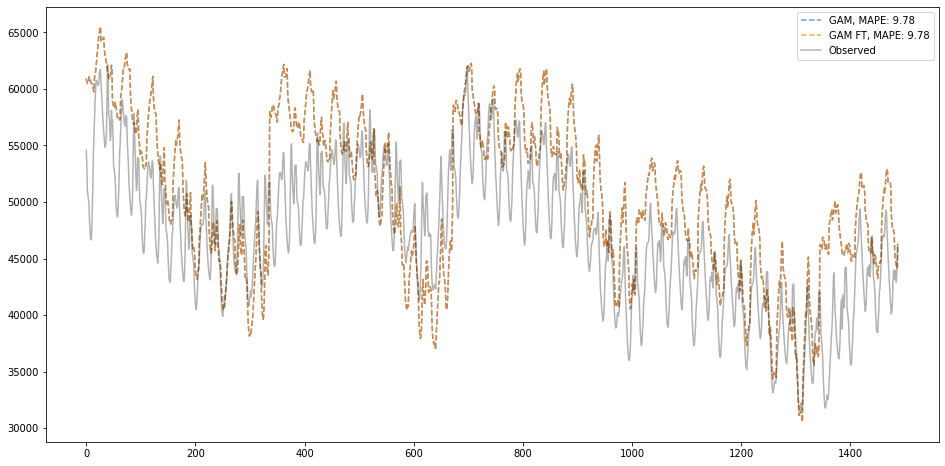

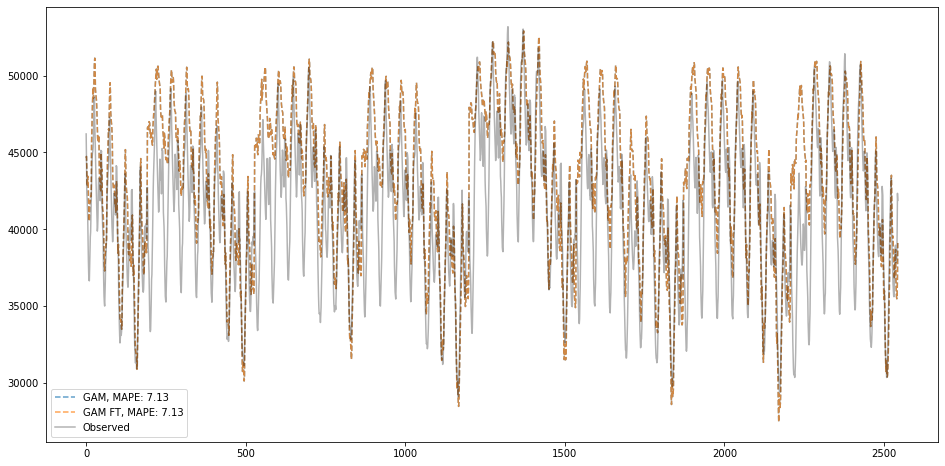

In [8]:
display_plots(type='test1', method='ft')
display_plots(type='test2', method='ft')